In [16]:
%env PATH=/usr/local/cuda-11.5/bin:/usr/bin:$PATH
%load_ext autoreload
%autoreload 2
%matplotlib widget

env: PATH=/usr/local/cuda-11.5/bin:/usr/bin:$PATH
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from pinns.prelude import *
from pinns.domain import Hypercube
from pinns.calc import laplace
from scipy.stats.qmc import Sobol
from pinns.model import mlp
from pinns.opt import train_nn

import itertools
import numpy as np
import matplotlib.pyplot as plt
from jax.config import config


In [148]:
def v(x, x0):
    return maximum(1 - norm((x - x0), axis=-1) ** 2 / 0.5 ** 2, 0)
    #return prod(maximum(1 - abs(x - x0) / 0.5, 0), axis=-1)


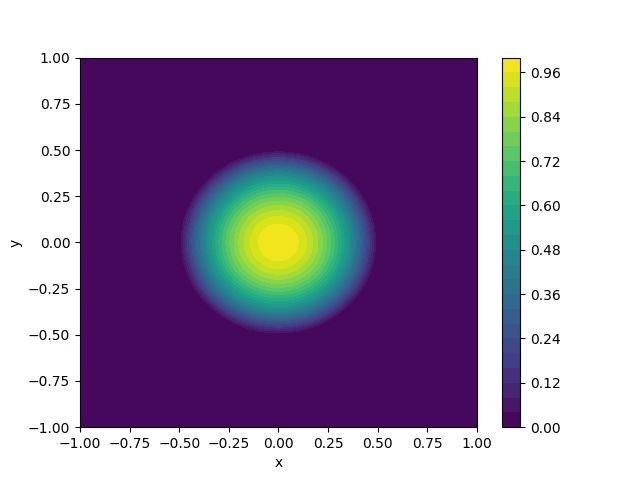

In [149]:

ax = plt.figure().add_subplot()

x = jnp.linspace(-1, 1, 100)
y = jnp.linspace(-1, 1, 100)
X, Y = jnp.meshgrid(x, y)
Z = v(stack([X, Y], axis=-1), array([0, 0.]))

p = ax.contourf(X, Y, Z, 30)

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(p)


In [129]:
def simpson(f, a, b):
    m = (a + b) / 2
    return (b - a) / 6 * (f(a) + 4 * f(m) + f(b))

def gauss_quad2(f, a, b):
    def trans(x):
        return (a + b) / 2 + x * (b - a) / 2
    return (b - a) / 2 * (f(trans(-1 / sqrt(3))) + f(trans(1 / sqrt(3))))

def gauss_quad3(f, a, b):
    def trans(x):
        return (a + b) / 2 + x * (b - a) / 2
    return (b - a) / 2 * (
        8 / 9 * f(trans(0.)) + 
        5 / 9 * f(trans(-sqrt(1 / 5))) + 
        5 / 9 * f(trans(sqrt(1 / 5)))
    )

def gauss_quad4(f, a, b):
    def trans(x):
        return (a + b) / 2 + x * (b - a) / 2
    u, v = sqrt(3 / 7 - 2 / 7 * sqrt(6 / 5)), sqrt(3 / 7 + 2 / 7 * sqrt(6 / 5))
    w1, w2 = (18 + sqrt(30)) / 36, (18 - sqrt(30)) / 36
    return (b - a) / 2 * (
        w1 * f(trans(u)) + 
        w1 * f(trans(-u)) + 
        w2 * f(trans(v)) + 
        w2 * f(trans(-v))
    )

def gauss_quad5(f, a, b):
    def trans(x):
        return (a + b) / 2 + x * (b - a) / 2
    u = 1 / 3 * sqrt(5 - 2 * sqrt(10 / 7))
    v = 1 / 3 * sqrt(5 + 2 * sqrt(10 / 7))
    w0 = 128 / 225
    w1 = (322 + 13 * sqrt(70)) / 900
    w2 = (322 - 13 * sqrt(70)) / 900
    return (b - a) / 2 * (
        w0 * f(trans(0.)) + 
        w1 * f(trans(u)) + 
        w1 * f(trans(-u)) + 
        w2 * f(trans(v)) + 
        w2 * f(trans(-v))
    )

@partial(jit, static_argnames=('f', 'method'))
def integrate(f, support, *args, method=simpson, **kwargs):

    if not isinstance(support, (list, tuple)):
        assert len(support.shape) > 0
        assert len(support.shape) <= 2
        if len(support.shape) == 1:
            support = [support]

    def g(*int_args):
        return f(stack(int_args), *args, **kwargs)

    def _integrate(f, support):
        a = support[:-1]
        b = support[1:]
        return sum(vmap(method, (None, 0, 0))(f, a, b))

    def _int(f, s):
        return lambda *args: _integrate(partial(f, *args), s)
    
    _f = g
    for s in support:
        _f = _int(_f, s)

    return _f()

@partial(jit, static_argnames=('f', 'method', 'n'))
def integrate_sphere(f, r, o, n, *args, method=simpson, **kwargs):
    def g(u, *args, **kwargs):
        r, phi, theta = u
        x = r * sin(phi) * cos(theta)
        y = r * sin(phi) * sin(theta)
        z = r * cos(phi)
        p = stack([x, y, z]) + o
        return f(p, *args, **kwargs) * r ** 2 * sin(phi)
    
    support = [
        jnp.linspace(0, 2 * pi, n),
        jnp.linspace(0, pi, n),
        jnp.linspace(0, r, n),
    ]
    return integrate(g, support, *args, method=method, **kwargs)

@partial(jit, static_argnames=('f', 'method', 'n'))
def integrate_sphere2(f, r, o, n, *args, method=simpson, **kwargs):
    def trans(x):
        u = 2 * x[0] - 1
        phi = 2 * pi * x[1]
        rad = x[2] ** (1 / 3)
        x1 = rad * sin(phi) * sqrt(1 - u**2)
        x2 = rad * cos(phi) * sqrt(1 - u**2)
        x3 = rad * u
        return stack((x1, x2, x3), -1) * r + o
    
    def g(x, *args, **kwargs):
        return f(trans(x), *args, **kwargs) * 8 * pi * r ** 3 * x[0] / 3
    
    support = [
        jnp.linspace(0., 1., n),
        jnp.linspace(0., 1., n),
        jnp.linspace(0., 1., n),
    ]
    return integrate(g, support, *args, method=method, **kwargs)


f = lambda t: 4 * cos(t) + 4 * sin(t)
s = jnp.linspace(0, pi / 2, 30)
assert integrate(f, s) == 8

f = lambda x: x[0] ** 2 * x[1] * (cos(pi * x[2]) + 2)
s = [
    jnp.linspace(0, 5, 10),
    jnp.linspace(0, 2, 5),
    jnp.linspace(0, 3, 5),
]
assert integrate(f, s) == 180

f = lambda x: x[0] ** 2 + x[1] ** 2 + x[2] ** 2
# f = lambda x: sin(x[0]) * 2 * cos(x[1])# + x[2]**3
f = lambda x: x[0] ** 2 * x[2] ** 2 * sqrt(x[1] ** 2)
integrate_sphere(f, 0.2, array([0., 0., 0.]), 40)



DeviceArray(8.363985e-08, dtype=float32)

In [130]:
integrate_sphere2(f, 0.2, array([0., 0., 0.]), 40)

DeviceArray(8.384782e-08, dtype=float32)

In [139]:
print(integrate_sphere(f, 0.2, array([0., 0., 0.]), 5, method=gauss_quad2))
print(integrate_sphere2(f, 0.2, array([0., 0., 0.]), 5, method=gauss_quad2))
print(integrate_sphere(f, 0.2, array([0., 0., 0.]), 5, method=gauss_quad3))
print(integrate_sphere2(f, 0.2, array([0., 0., 0.]), 5, method=gauss_quad3))
print(integrate_sphere(f, 0.2, array([0., 0., 0.]), 5, method=gauss_quad4))
print(integrate_sphere2(f, 0.2, array([0., 0., 0.]), 5, method=gauss_quad4))
print(integrate_sphere(f, 0.2, array([0., 0., 0.]), 5, method=gauss_quad5))
print(integrate_sphere2(f, 0.2, array([0., 0., 0.]), 5, method=gauss_quad5))

7.7199914e-08
7.6404575e-08
1.0669703e-07
1.2529209e-07
8.376751e-08
8.374245e-08
8.377597e-08
8.376762e-08


In [92]:
integrate_sphere2(f, 3, array([0., 0., 0.]), 2, method=gauss_quad4)

DeviceArray(611.27924, dtype=float32)

In [256]:
4 / 3 * pi

4.1887902047863905

In [254]:
def trans(x):
    u = 2 * x[0] - 1
    phi = 2 * pi * x[1]
    rad = x[2] ** (1 / 3)
    x1 = rad * cos(phi) * sqrt(1 - u**2)
    x2 = rad * sin(phi) * sqrt(1 - u**2)
    x3 = rad * u
    return stack((x1, x2, x3), -1)

jacfwd(trans)([1., 1., 0.])

[DeviceArray([nan, nan, nan], dtype=float32, weak_type=True),
 DeviceArray([nan, nan, nan], dtype=float32, weak_type=True),
 DeviceArray([nan, nan, inf], dtype=float32, weak_type=True)]

In [34]:
import sympy as sp

x, y, z = sp.symbols("x y z")
r, u, v, w = sp.symbols("r u v w")
M = sp.Matrix([
    sp.root(z, 3) * sp.sin(2 * sp.pi * y) * sp.sqrt(1 - (2 * x - 1)**2),
    sp.root(z, 3) * sp.cos(2 * sp.pi * y) * sp.sqrt(1 - (2 * x - 1)**2),
    sp.root(z, 3) * 2 * x - 1
])
o = sp.Matrix([u, v, w])
(M * r + o).jacobian([x, y, z]).det().simplify()

8*pi*r**3*x/3